In [57]:
from pathlib import Path
from typing import *

import os
import sys
import json
import pickle

from scipy.special import huber
from scipy.stats import linregress
from numpy.polynomial import Polynomial
from sklearn.linear_model import HuberRegressor

import optuna
import numpy as np
import pandas as pd
import mplhep as hep
import matplotlib.pyplot as plt

sys.path.insert(0, Path("./NonLinearity").absolute().as_posix())
from poggers.io import read_fill
from poggers.models import sub_nl

In [70]:
def read_plt_fpm_alphas(path: Path, label: str="lead") -> Dict[int, float]:
    if label not in ("lead", "train"):
        raise ValueError(f"'label' parameter should only be 'lead' or 'train'. Got '{label}' instead.")
    results = pd.read_pickle(path)
    return {int(name.split("_")[-1]): res[f"alpha_{label}"] for name, res in results.items()}

def read_dt_collinearity_alphas(path: Path) -> Dict[int, float]:
    with open(path) as fp:
        results = json.load(fp)
    return {int(ch): res['alpha'] for ch, res in results.items()}

def get_channels(good_channels: Set[int], existing_channels: Set[int]) -> List[int]:
    existing_good_channels = existing_channels.intersection(good_channels)
    if existing_good_channels != good_channels:
        print(f"Fill data missing some channels. Missing channels are: {good_channels - existing_good_channels}")
    return existing_good_channels

SlopeInterceptFitter = Callable[[np.ndarray, np.ndarray], np.ndarray]
def default_fitter(x: np.ndarray, y: np.ndarray, **kwargs) -> np.ndarray:
    deg = kwargs.pop("deg") if "deg" in kwargs else 1
    p: Polynomial = Polynomial.fit(x, y, deg, **kwargs)
    return p.convert().coef

def compute_intercepts_and_slopes(data: np.ndarray, fitter: SlopeInterceptFitter, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
    N = data.shape[0]
    slopes = np.ones((N, N))
    intercepts = np.ones((N, N))

    I, J = np.triu_indices(N, k=1)
    for i, j in zip(I, J):
        ratio = data[i] / data[j]
        intercept, slope = fitter(data[j], ratio, **kwargs)
        intercepts[i, j] = intercept
        intercepts[j, i] = 1 / intercept
        slopes[i, j] = slope
        slopes[j, i] = -slope

    return intercepts, slopes

def objective(data: np.ndarray, alphas: np.ndarray, intercepts: np.ndarray, delta: float = 1.0):
    def func(x: np.ndarray, a1: float, a2: float, c: float) -> np.ndarray:
        x1, x2 = np.split(x, 2)
        N = 1 + np.sqrt(4 * a1 * x1 + 1)
        D = 1 + np.sqrt(4 * a2 * x2 + 1)
        return c * N / D

    N = intercepts.shape[0]
    I, J = np.triu_indices(N, k=1)
    
    total = 0
    for i, j in list(zip(I, J)):
        rm1, rm2 = data[i], data[j]
        intercept = intercepts[i, j]
        a1, a2 = alphas[i], alphas[j]

        y_fit = func(np.concatenate([rm1, rm2]), a1, a2, intercept)
        y = rm1 / rm2
        residual = y_fit - y
        total += np.sum(huber(delta, residual))

    return total

def optuna_objective_wrapper(trial: optuna.Trial, data: np.ndarray, intercepts: np.ndarray, alphas: np.ndarray, alpha_percentage: float):
    lower_bounds = alphas * (1 - alpha_percentage)
    upper_bounds = alphas * (1 + alpha_percentage)

    test_alphas = np.array([
        trial.suggest_float(f"alpha_{i}", lower_bounds[i], upper_bounds[i])
        for i in range(len(alphas))
    ])
    return objective(data, test_alphas, intercepts)

def plot_corrected_ratios(channel_map: List[int], **datas: np.ndarray):
    N = datas[next(iter(datas))].shape[0]
    fig, axes = plt.subplots(N - 1, N - 1, figsize=(25, 15))

    # Assign default colors by matplotlib’s color cycling
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {label: color_cycle[i % len(color_cycle)] for i, label in enumerate(datas.keys())}

    for i in range(N - 1):
        for j in range(i + 1, N):
            for label, data in datas.items():
                original_ratio = data[i] / data[j]
                ax: plt.Axes = axes[i, j - 1]
                ax.scatter(data[j], original_ratio, s=10, color=color_map[label], label=label)

                chi, chj = channel_map[i], channel_map[j]
                ax.set_title(f'Ratio: Detector {chi}/{chj}', fontsize=10)
                ax.tick_params(axis="both", labelsize=8)

    for i in range(N - 1):
        for j in range(i):
            axes[i, j].axis("off")

    num_labels = len(datas)
    spacing = 1 / (num_labels + 1)
    for idx, (label, color) in enumerate(color_map.items()):
        x_position = spacing * (idx + 1)  # Calculate x position based on label index
        fig.text(x_position, 0.98, label, ha='center', va='top', color=color, fontsize=25, weight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

[I 2024-12-16 19:33:32,054] A new study created in memory with name: NLStudy
[I 2024-12-16 19:33:32,061] Trial 0 finished with value: 5.039907429914653 and parameters: {'alpha_0': 0.2590122601108805, 'alpha_1': 0.48625564711743635, 'alpha_2': 0.40660789365002453, 'alpha_3': 0.4350997471021893, 'alpha_4': 0.48165992157200904, 'alpha_5': 0.5555216993782816, 'alpha_6': 0.49038135255404003, 'alpha_7': 0.4973070000072295, 'alpha_8': 0.42871168473460053}. Best is trial 0 with value: 5.039907429914653.
[I 2024-12-16 19:33:32,068] Trial 1 finished with value: 3.0969717211708736 and parameters: {'alpha_0': 0.2953936188956596, 'alpha_1': 0.33297721121116586, 'alpha_2': 0.4420173745031703, 'alpha_3': 0.47424280034801125, 'alpha_4': 0.49424205456837605, 'alpha_5': 0.5621772699774054, 'alpha_6': 0.5202416706416169, 'alpha_7': 0.3998064804305017, 'alpha_8': 0.416126383671201}. Best is trial 1 with value: 3.0969717211708736.
[I 2024-12-16 19:33:32,075] Trial 2 finished with value: 2.1788175296148657 

[I 2024-12-16 19:33:32,206] Trial 11 finished with value: 3.0604670023008627 and parameters: {'alpha_0': 0.3167428670089846, 'alpha_1': 0.3338587273309338, 'alpha_2': 0.43843050564676767, 'alpha_3': 0.48921906610828264, 'alpha_4': 0.543841240023744, 'alpha_5': 0.5940720057202624, 'alpha_6': 0.5337425915817771, 'alpha_7': 0.41959100843981717, 'alpha_8': 0.4070921555254467}. Best is trial 2 with value: 2.1788175296148657.
[I 2024-12-16 19:33:32,250] Trial 12 finished with value: 2.778868943198577 and parameters: {'alpha_0': 0.32048684361249374, 'alpha_1': 0.3533302036730533, 'alpha_2': 0.4375620890927838, 'alpha_3': 0.4990482307311203, 'alpha_4': 0.5604177496374366, 'alpha_5': 0.6125941662753206, 'alpha_6': 0.5569961216938589, 'alpha_7': 0.4376704809883536, 'alpha_8': 0.3865544389811685}. Best is trial 2 with value: 2.1788175296148657.
[I 2024-12-16 19:33:32,295] Trial 13 finished with value: 3.904287100074381 and parameters: {'alpha_0': 0.23242124729112673, 'alpha_1': 0.3604890154826023

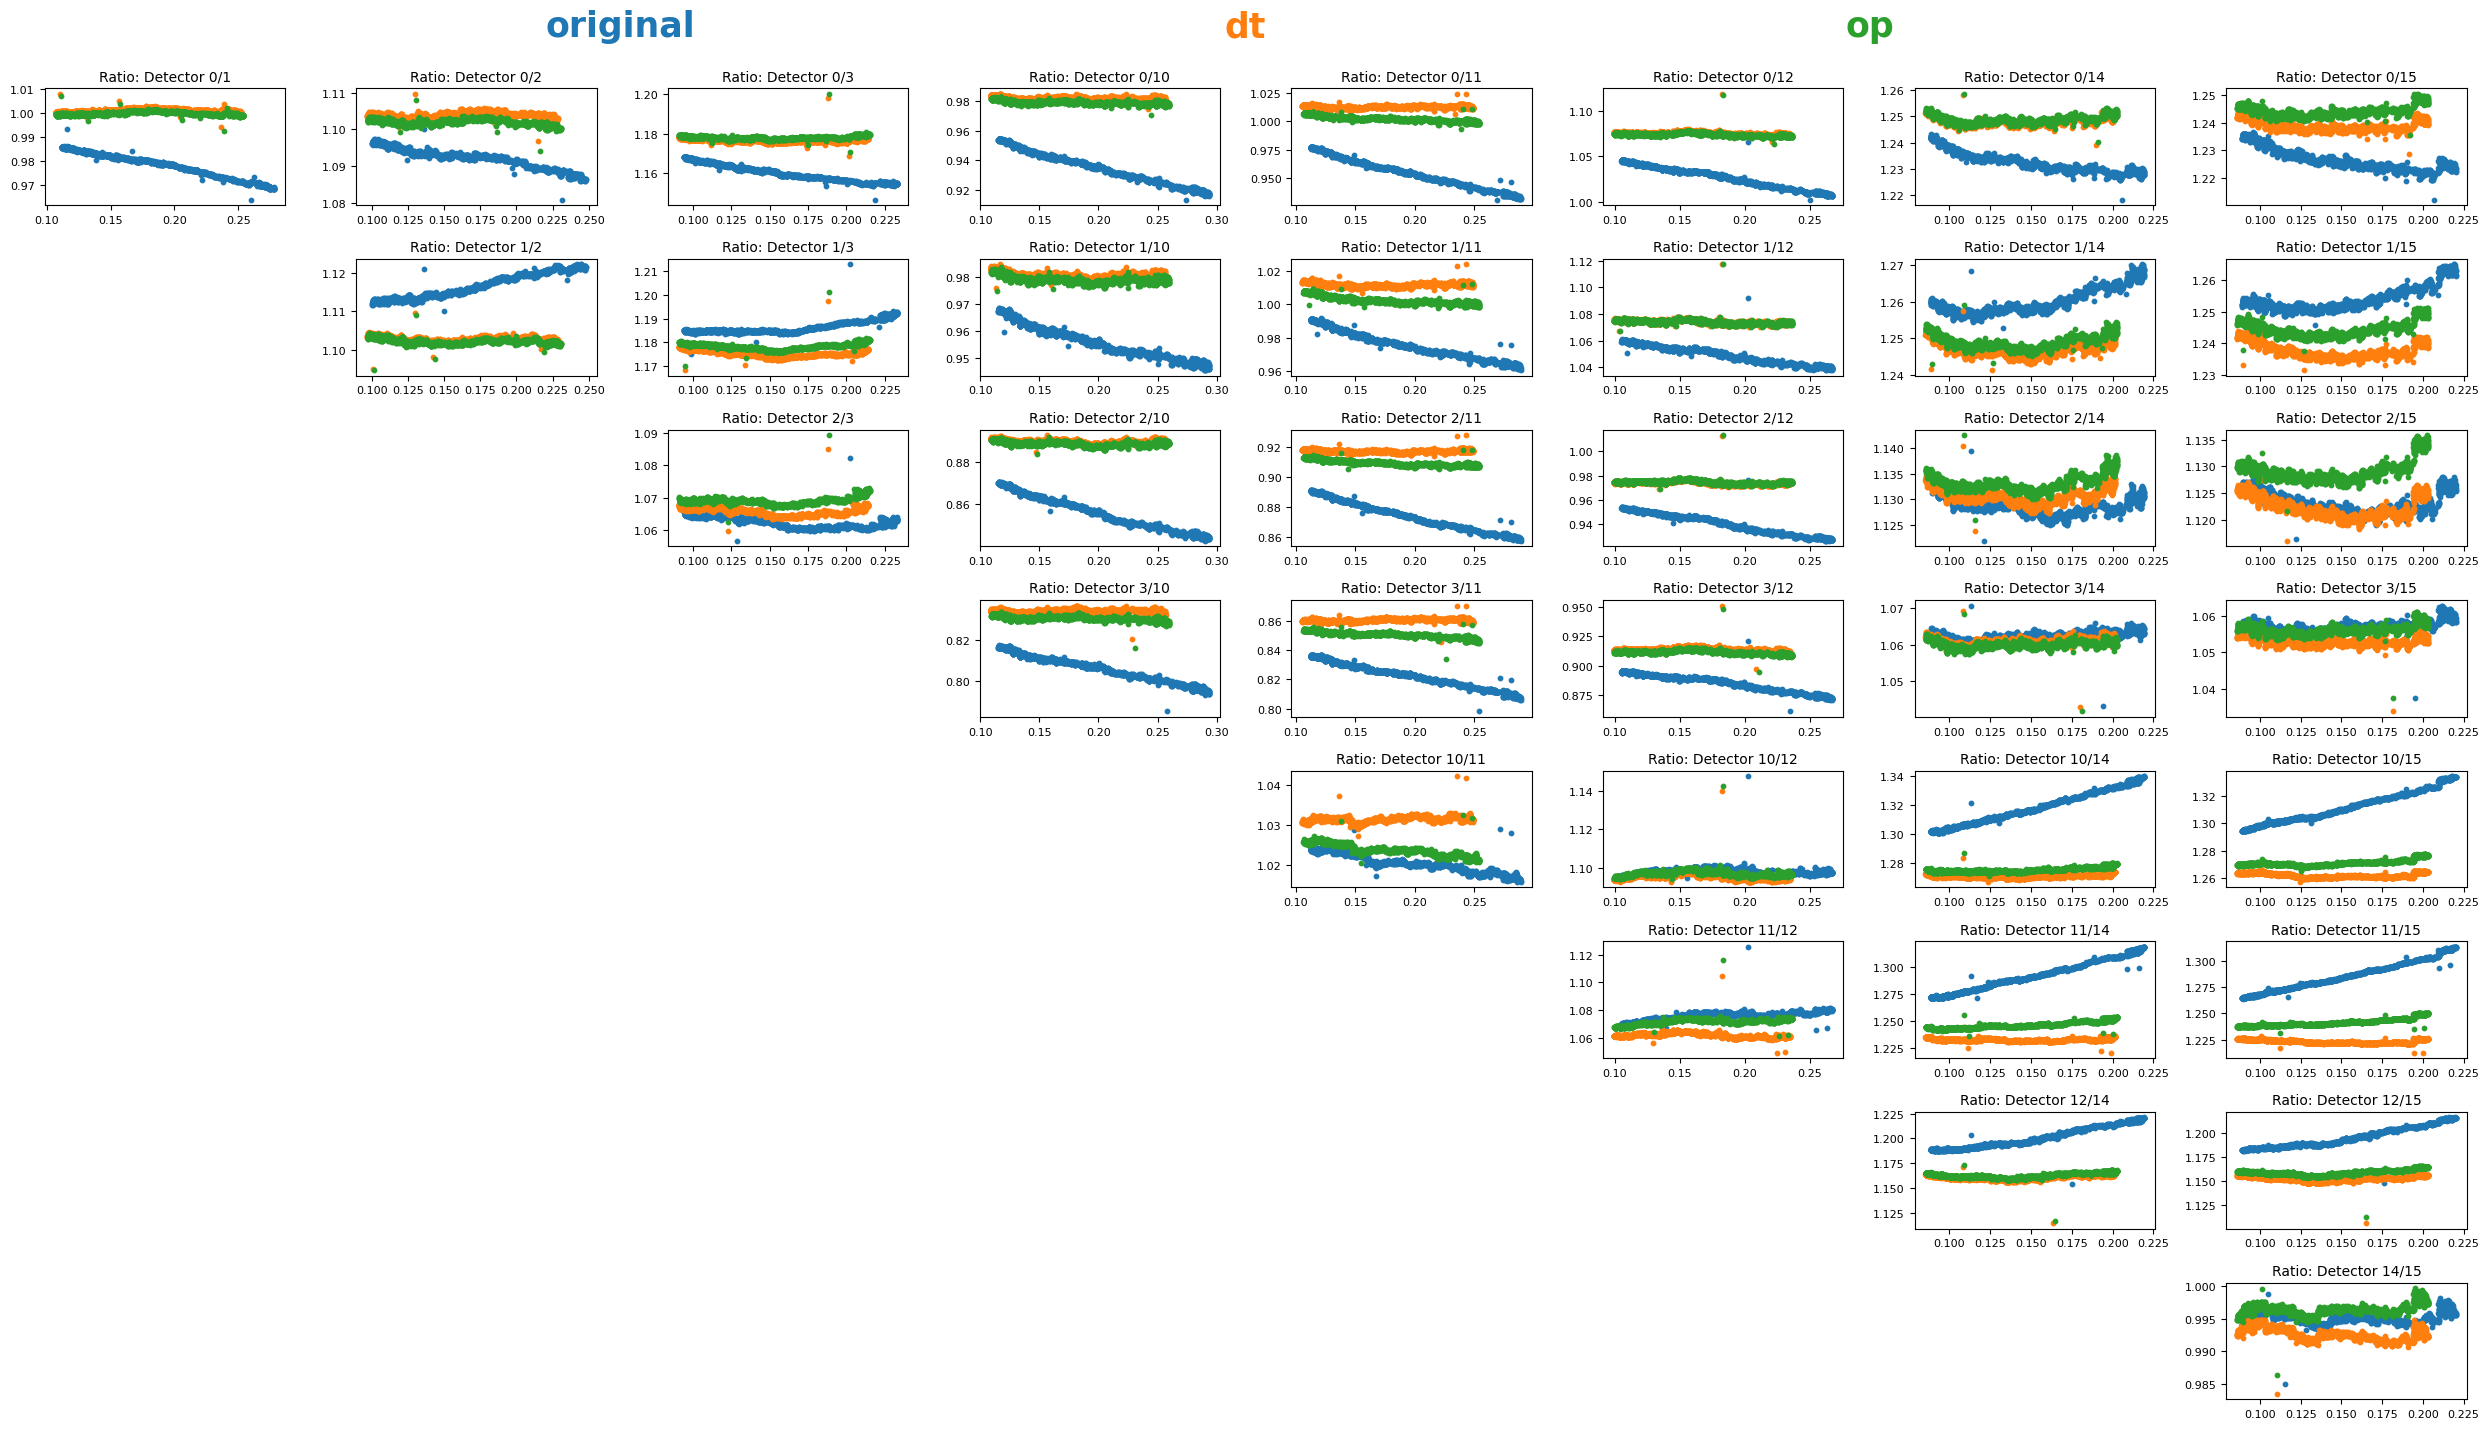

In [76]:
output = Path("simultaneous_fit_studies")
plt_poggers = Path("/localdata/flpereir/NonLinearity/poggers_plt_example")
dt_path = Path("/localdata/flpereir/NonLinearity/collinearity_8880/collinearity.json")
alpha_from = "DT"
good_channels = {0, 1, 2, 3, 10, 11, 12, 14, 15}
fill = 8880
bound = 0.2
n_trials = 100

if alpha_from == "DT":
    alphas = read_dt_collinearity_alphas(dt_path)
elif alpha_from == "FPM":
    alphas = read_plt_fpm_alphas(plt_poggers)

attrs, df = read_fill(plt_poggers, fill, "det", remove_scans=True, index_filter=(0.2, 0.95))
channels = list(get_channels(good_channels, set(df.filter(regex="\d+").columns)))
initial_alphas = np.array([alphas[ch] for ch in channels])

normalized_rates = df[channels].values.T / attrs["nbx"]
intercepts, _ = compute_intercepts_and_slopes(normalized_rates, default_fitter)

output.mkdir(exist_ok=True, parents=True)
study = optuna.create_study(
    study_name="NLStudy",
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
)
study.optimize(
    lambda trial: optuna_objective(trial, normalized_rates, intercepts, initial_alphas, bound),
    n_trials=n_trials
)

best_alphas = np.array(list(study.best_params.values()))
dt_rates = sub_nl(normalized_rates, initial_alphas[:, np.newaxis], 1)
op_rates = sub_nl(normalized_rates, best_alphas[:, np.newaxis], 1)
fig = plot_corrected_ratios(
    channels, 
    original=normalized_rates,
    dt=dt_rates,
    op=op_rates
)

trials_df = study.trials_dataframe()
trials_df.to_csv(output / "trials.csv", index=False)
with open(output / "study.pickle", "wb") as fp:
    pickle.dump(study, fp)

In [75]:
best_alphas / initial_alphas

array([0.88526625, 0.90136991, 0.87195275, 0.9331449 , 0.90544441,
       0.83505127, 0.92233722, 0.91705408, 0.98504224])